# FaultSense Hotline Notebook

This notebook documents the full ML lifecycle for the FaultSense Hotline audio fault classification problem. Run the cells sequentially to:

1. Fetch and curate the ESC-50 dataset and remap classes to our fault taxonomy.
2. Explore and visualize the curated dataset (waveforms, spectrograms, class balance, feature importance).
3. Extract log-mel + MFCC features and persist reusable artifacts.
4. Train, evaluate, and calibrate the CNN classifier with multiple metrics.
5. Package the model for deployment and log metadata for the API/UI layers.
6. Demonstrate the retraining trigger using freshly uploaded audio samples.



In [2]:
from pathlib import Path
import json

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image, display

DATA_DIR = Path("../data")
REPORT_DIR = Path("../reports/eda_visuals")

manifest = pd.read_csv(DATA_DIR / "curated" / "manifest.csv")
manifest.head()


,filepath,label,esc_category,fold
0,data/curated/normal_operation/1-100032-A-0.wav,normal_operation,dog,1
1,data/curated/normal_operation/1-110389-A-0.wav,normal_operation,dog,1
2,data/curated/mechanical_fault/1-116765-A-41.wav,mechanical_fault,chainsaw,1
3,data/curated/fluid_leak/1-12653-A-15.wav,fluid_leak,water_drops,1
4,data/curated/fluid_leak/1-12654-A-15.wav,fluid_leak,water_drops,1


## Dataset summary

- ESC-50 samples remapped to four operational states: `mechanical_fault`, `electrical_fault`, `fluid_leak`, `normal_operation`.
- Stratified 80/20 split materialized under `data/train` and `data/test` for reproducibility.
- All raw/curated metadata lives in `data/curated/manifest.csv` and the per-split manifests.


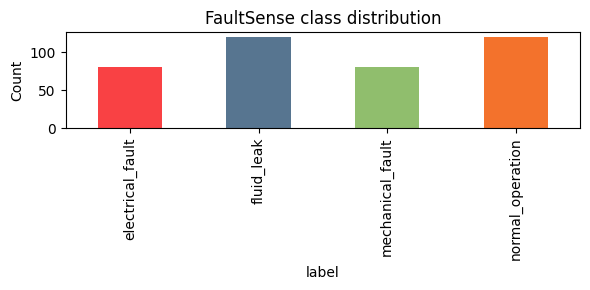

In [5]:
class_counts = manifest["label"].value_counts().sort_index()
ax = class_counts.plot(kind="bar", color=["#f94144", "#577590", "#90be6d", "#f3722c"], figsize=(6, 3))
ax.set_title("FaultSense class distribution")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()


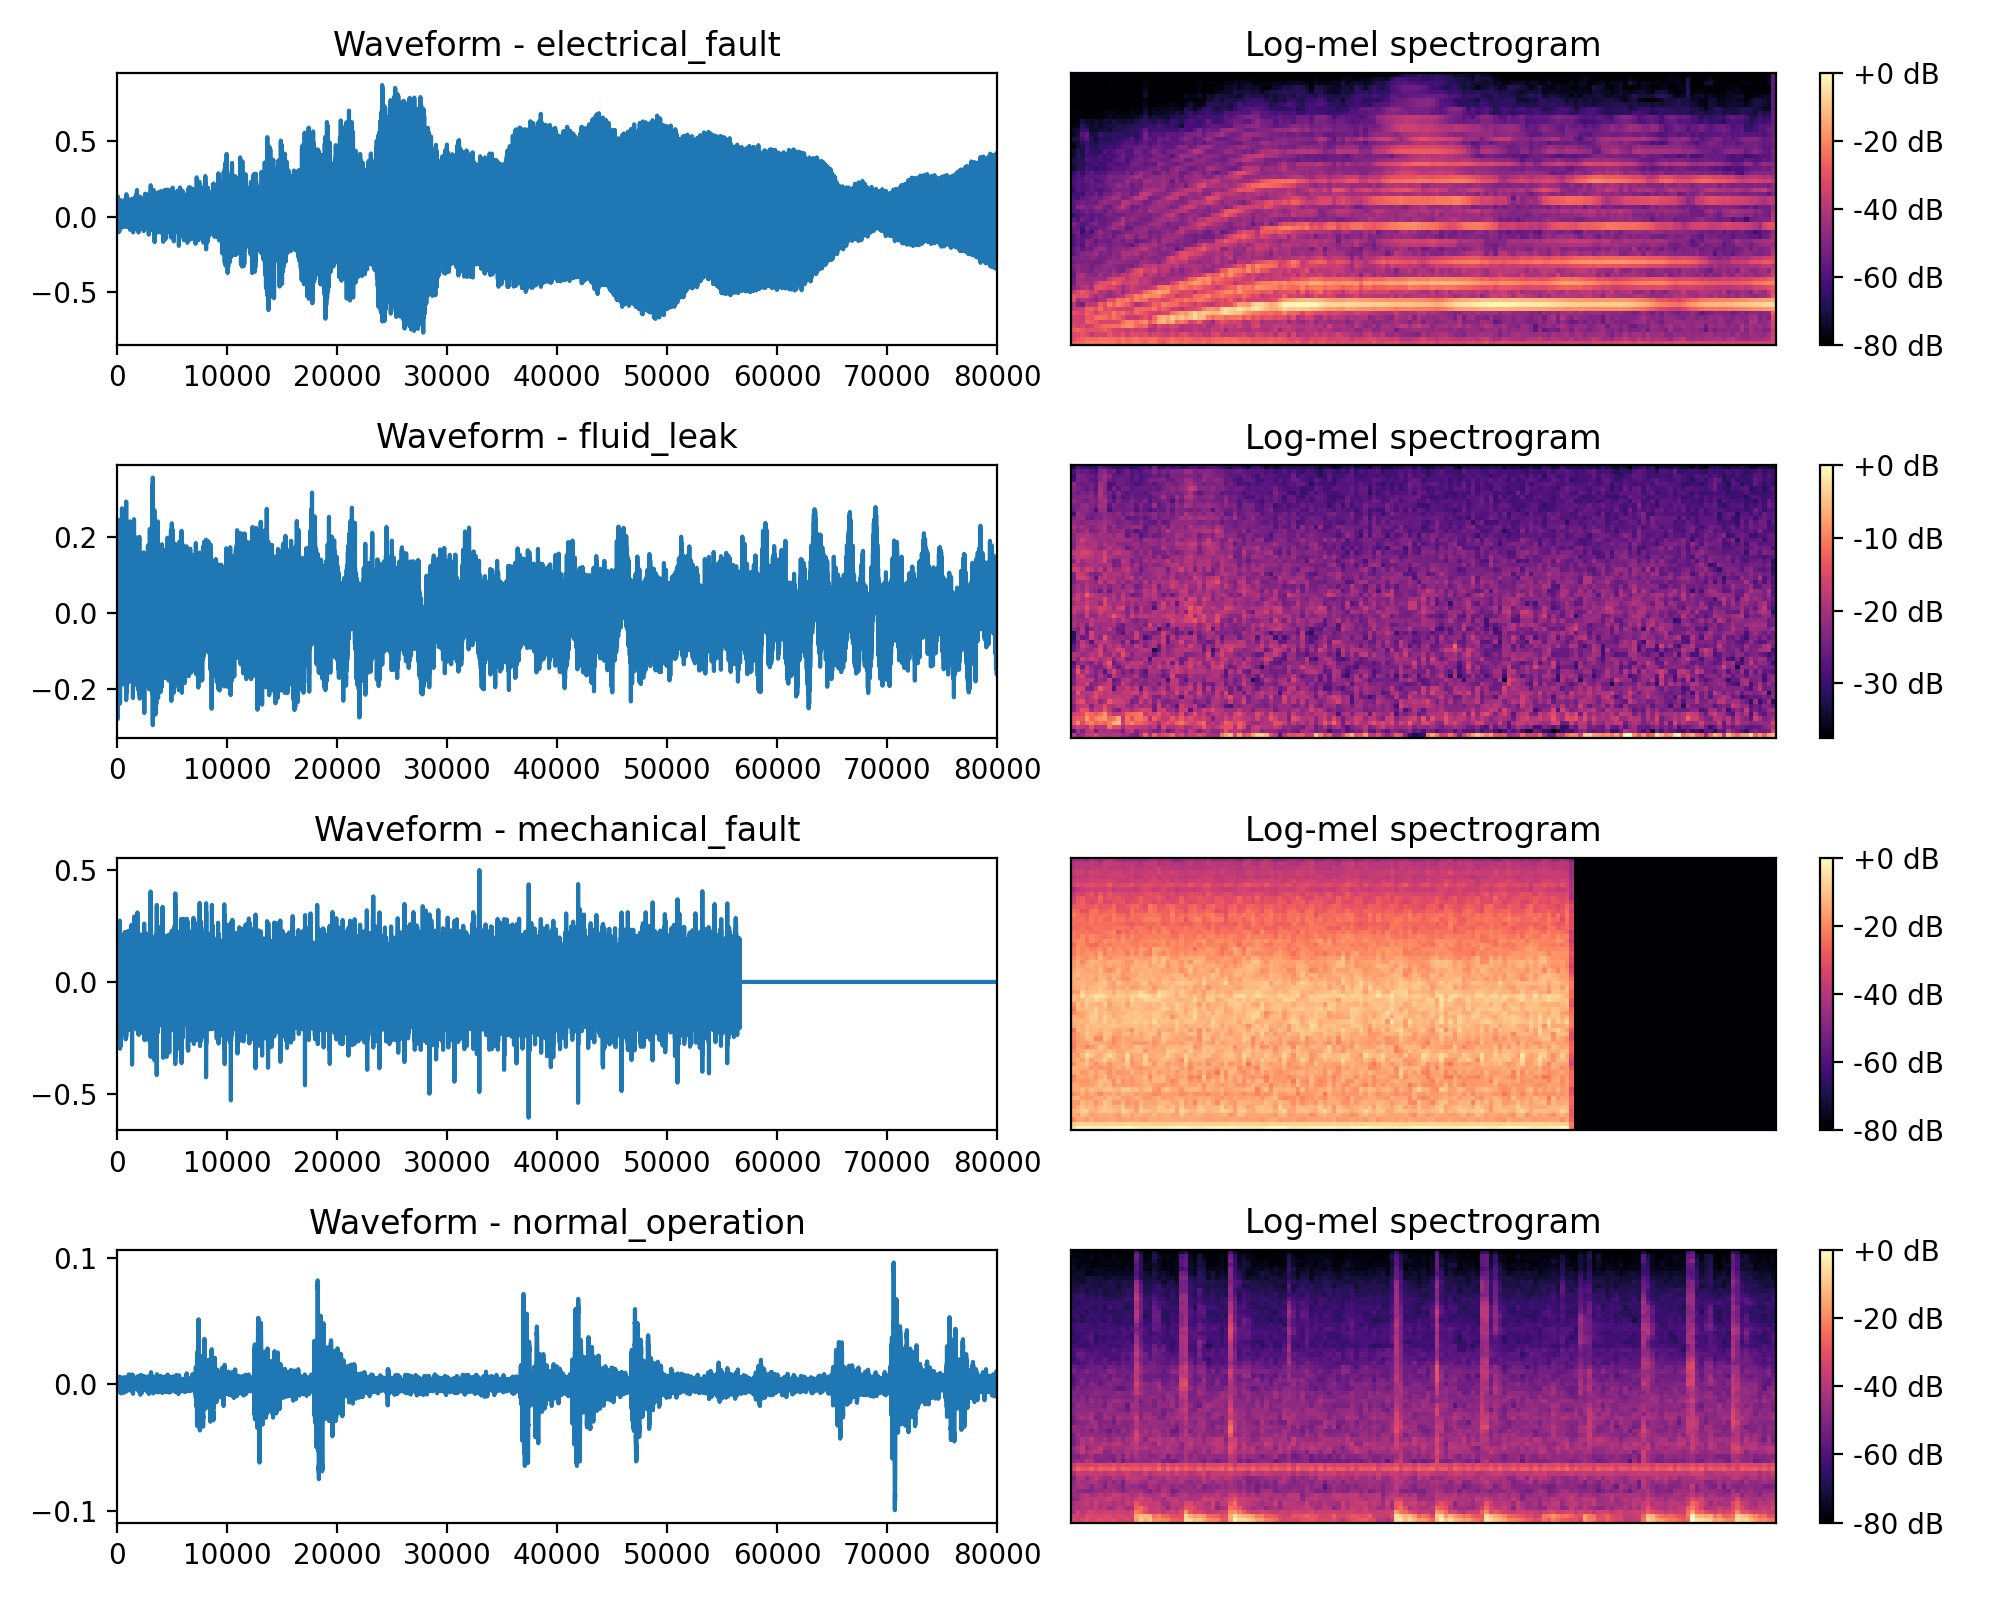

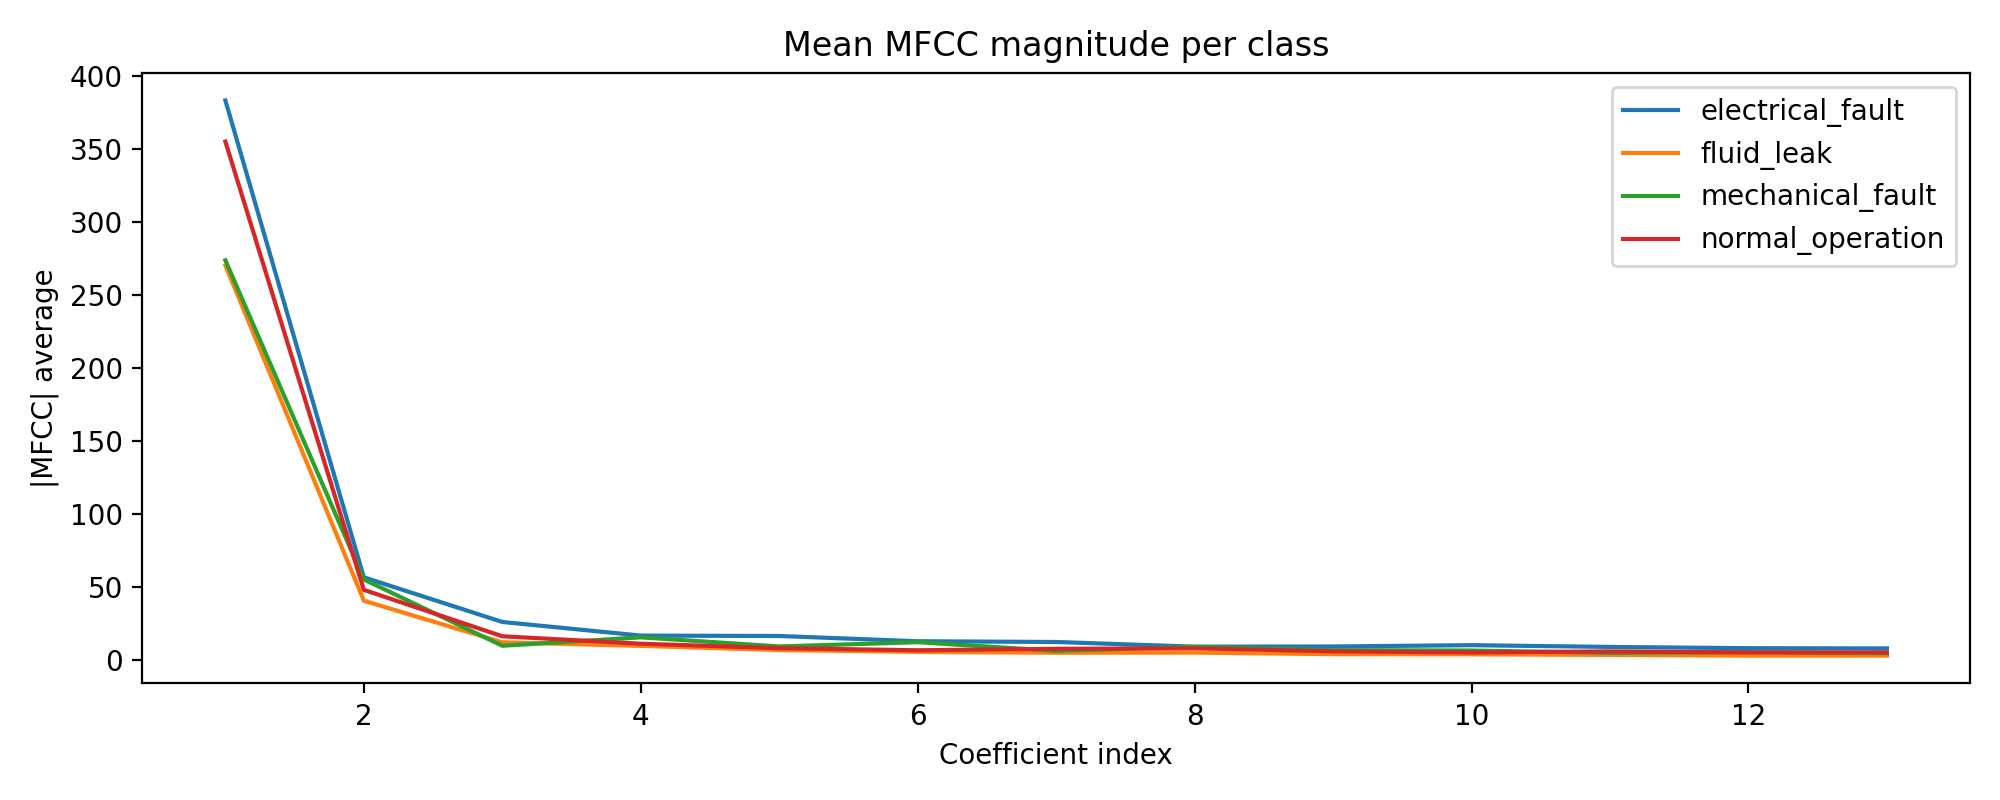

In [7]:
for image_name in ["sample_waveforms_spectrograms.png", "mfcc_trends.png"]:
    path = REPORT_DIR / image_name
    if path.exists():
        display(Image(filename=str(path)))
    else:
        print(f"Missing visualization: {path}")


## Model training & evaluation

The tuned CNN leverages class-weighted loss, stochastic feature noise augmentation, and a ReduceLROnPlateau scheduler. Metrics below are read from the latest `models/registry.json` artifact to keep this notebook lightweight.


In [8]:
registry = json.loads(Path("../models/registry.json").read_text())
history = pd.DataFrame(registry["history"])
history.tail()


,epoch,train_loss,train_accuracy,train_precision,train_recall,train_f1,val_loss,val_accuracy,val_precision,val_recall,val_f1,lr
35,36,0.025959,0.993750,0.993577,0.994792,0.994135,1.539131,0.6000,0.592943,0.583333,0.579726,0.000063
36,37,0.035169,0.993750,0.993550,0.993490,0.993489,1.558680,0.5875,0.573778,0.567708,0.565842,0.000063
37,38,0.025399,0.993750,0.994898,0.993490,0.994145,1.541047,0.5875,0.572802,0.572917,0.569004,0.000063
38,39,0.038294,0.996875,0.997423,0.997396,0.997396,1.543456,0.5875,0.576152,0.578125,0.571439,0.000031
39,40,0.025507,0.996875,0.997423,0.997396,0.997396,1.556391,0.6000,0.591601,0.588542,0.583109,0.000031


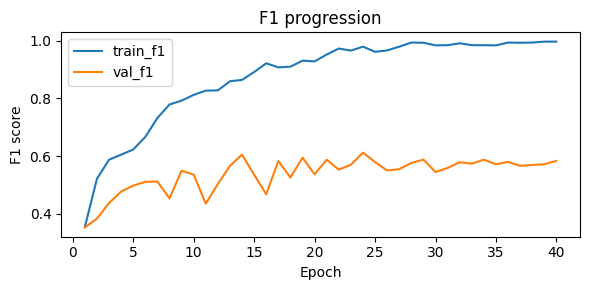

epoch            24.000000
val_accuracy      0.625000
val_precision     0.622548
val_recall        0.609375
val_f1            0.611840
Name: 23, dtype: float64

In [9]:
fig, ax = plt.subplots(figsize=(6, 3))
for metric in ["train_f1", "val_f1"]:
    ax.plot(history["epoch"], history[metric], label=metric)
ax.set_xlabel("Epoch")
ax.set_ylabel("F1 score")
ax.set_title("F1 progression")
ax.legend()
plt.tight_layout()
plt.show()

best_row = history.loc[history["val_f1"].idxmax()]
best_row[["epoch", "val_accuracy", "val_precision", "val_recall", "val_f1"]]


## Prediction demo

Use the `PredictionService` to score any WAV clip (e.g., one from `data/test`). The service internally mirrors the FastAPI inference flow.


In [12]:
from src.prediction import PredictionService

sample_path = Path("../data/test/electrical_fault/1-21935-A-38.wav")
service = PredictionService(Path("../data/artifacts"), Path("../models/faultsense_cnn.pt"))
service.predict_top(sample_path)


ModuleNotFoundError: No module named 'src'